In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to restrictive lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [3]:
tr_df = get_class_paths("Training")

In [4]:
tr_df

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [5]:
ts_df = get_class_paths("Testing")

In [6]:
ts_df


,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


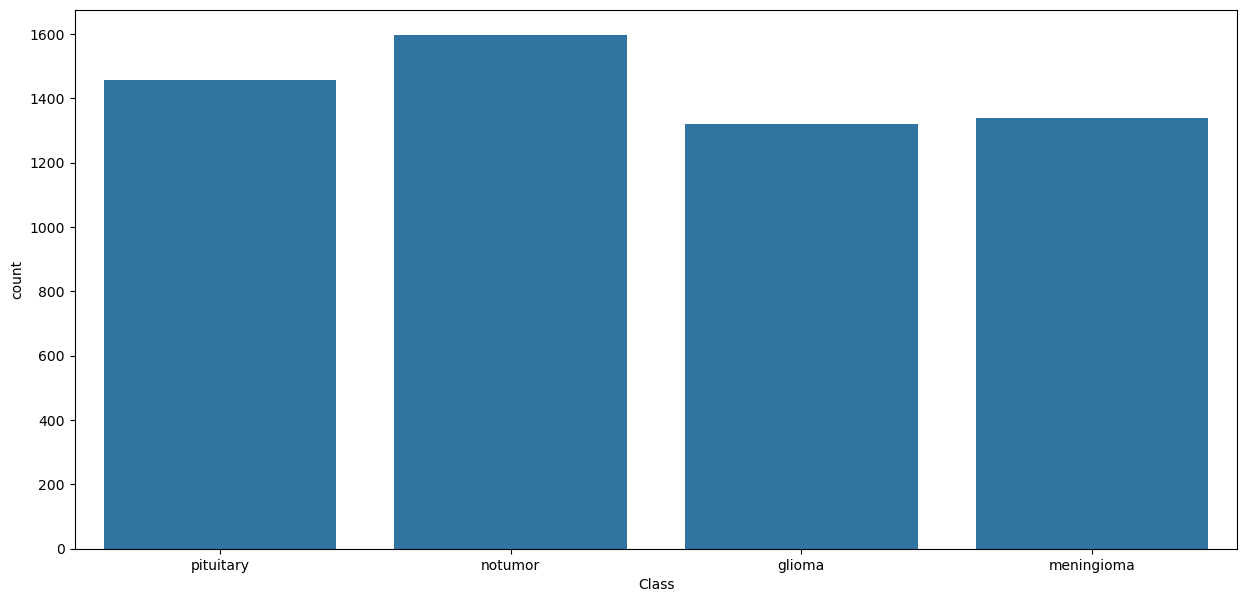

In [7]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df["Class"])

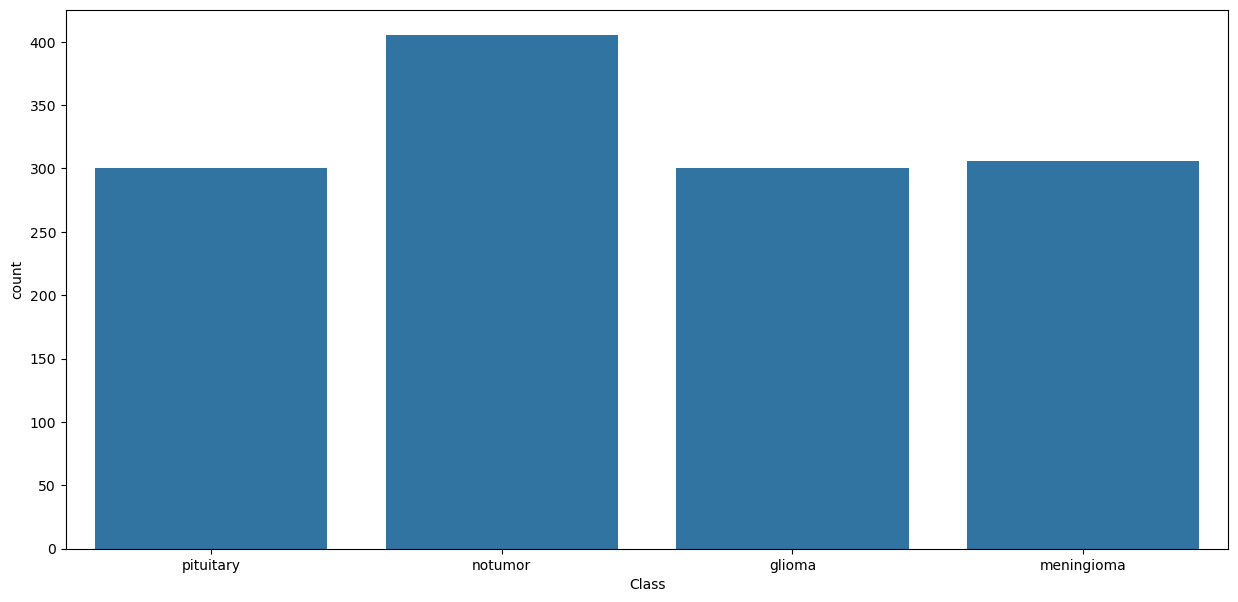

In [8]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df["Class"])

In [9]:
# !pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [11]:
valid_df

,Class Path,Class
147,Testing/pituitary/Te-pi_0243.jpg,pituitary
1206,Testing/meningioma/Te-me_0237.jpg,meningioma
483,Testing/notumor/Te-no_0381.jpg,notumor
1223,Testing/meningioma/Te-me_0292.jpg,meningioma
24,Testing/pituitary/Te-pi_0032.jpg,pituitary
...,...,...
1236,Testing/meningioma/Te-me_0091.jpg,meningioma
189,Testing/pituitary/Te-piTr_0008.jpg,pituitary
767,Testing/glioma/Te-gl_0056.jpg,glioma
1051,Testing/meningioma/Te-me_0060.jpg,meningioma


In [12]:
ts_df

,Class Path,Class
518,Testing/notumor/Te-no_0156.jpg,notumor
949,Testing/glioma/Te-gl_0271.jpg,glioma
385,Testing/notumor/Te-no_0268.jpg,notumor
406,Testing/notumor/Te-no_0121.jpg,notumor
33,Testing/pituitary/Te-pi_0033.jpg,pituitary
...,...,...
109,Testing/pituitary/Te-pi_0131.jpg,pituitary
504,Testing/notumor/Te-no_0209.jpg,notumor
936,Testing/glioma/Te-gl_0104.jpg,glioma
996,Testing/glioma/Te-gl_0114.jpg,glioma


In [13]:
batch_size = 32

img_size = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [14]:
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


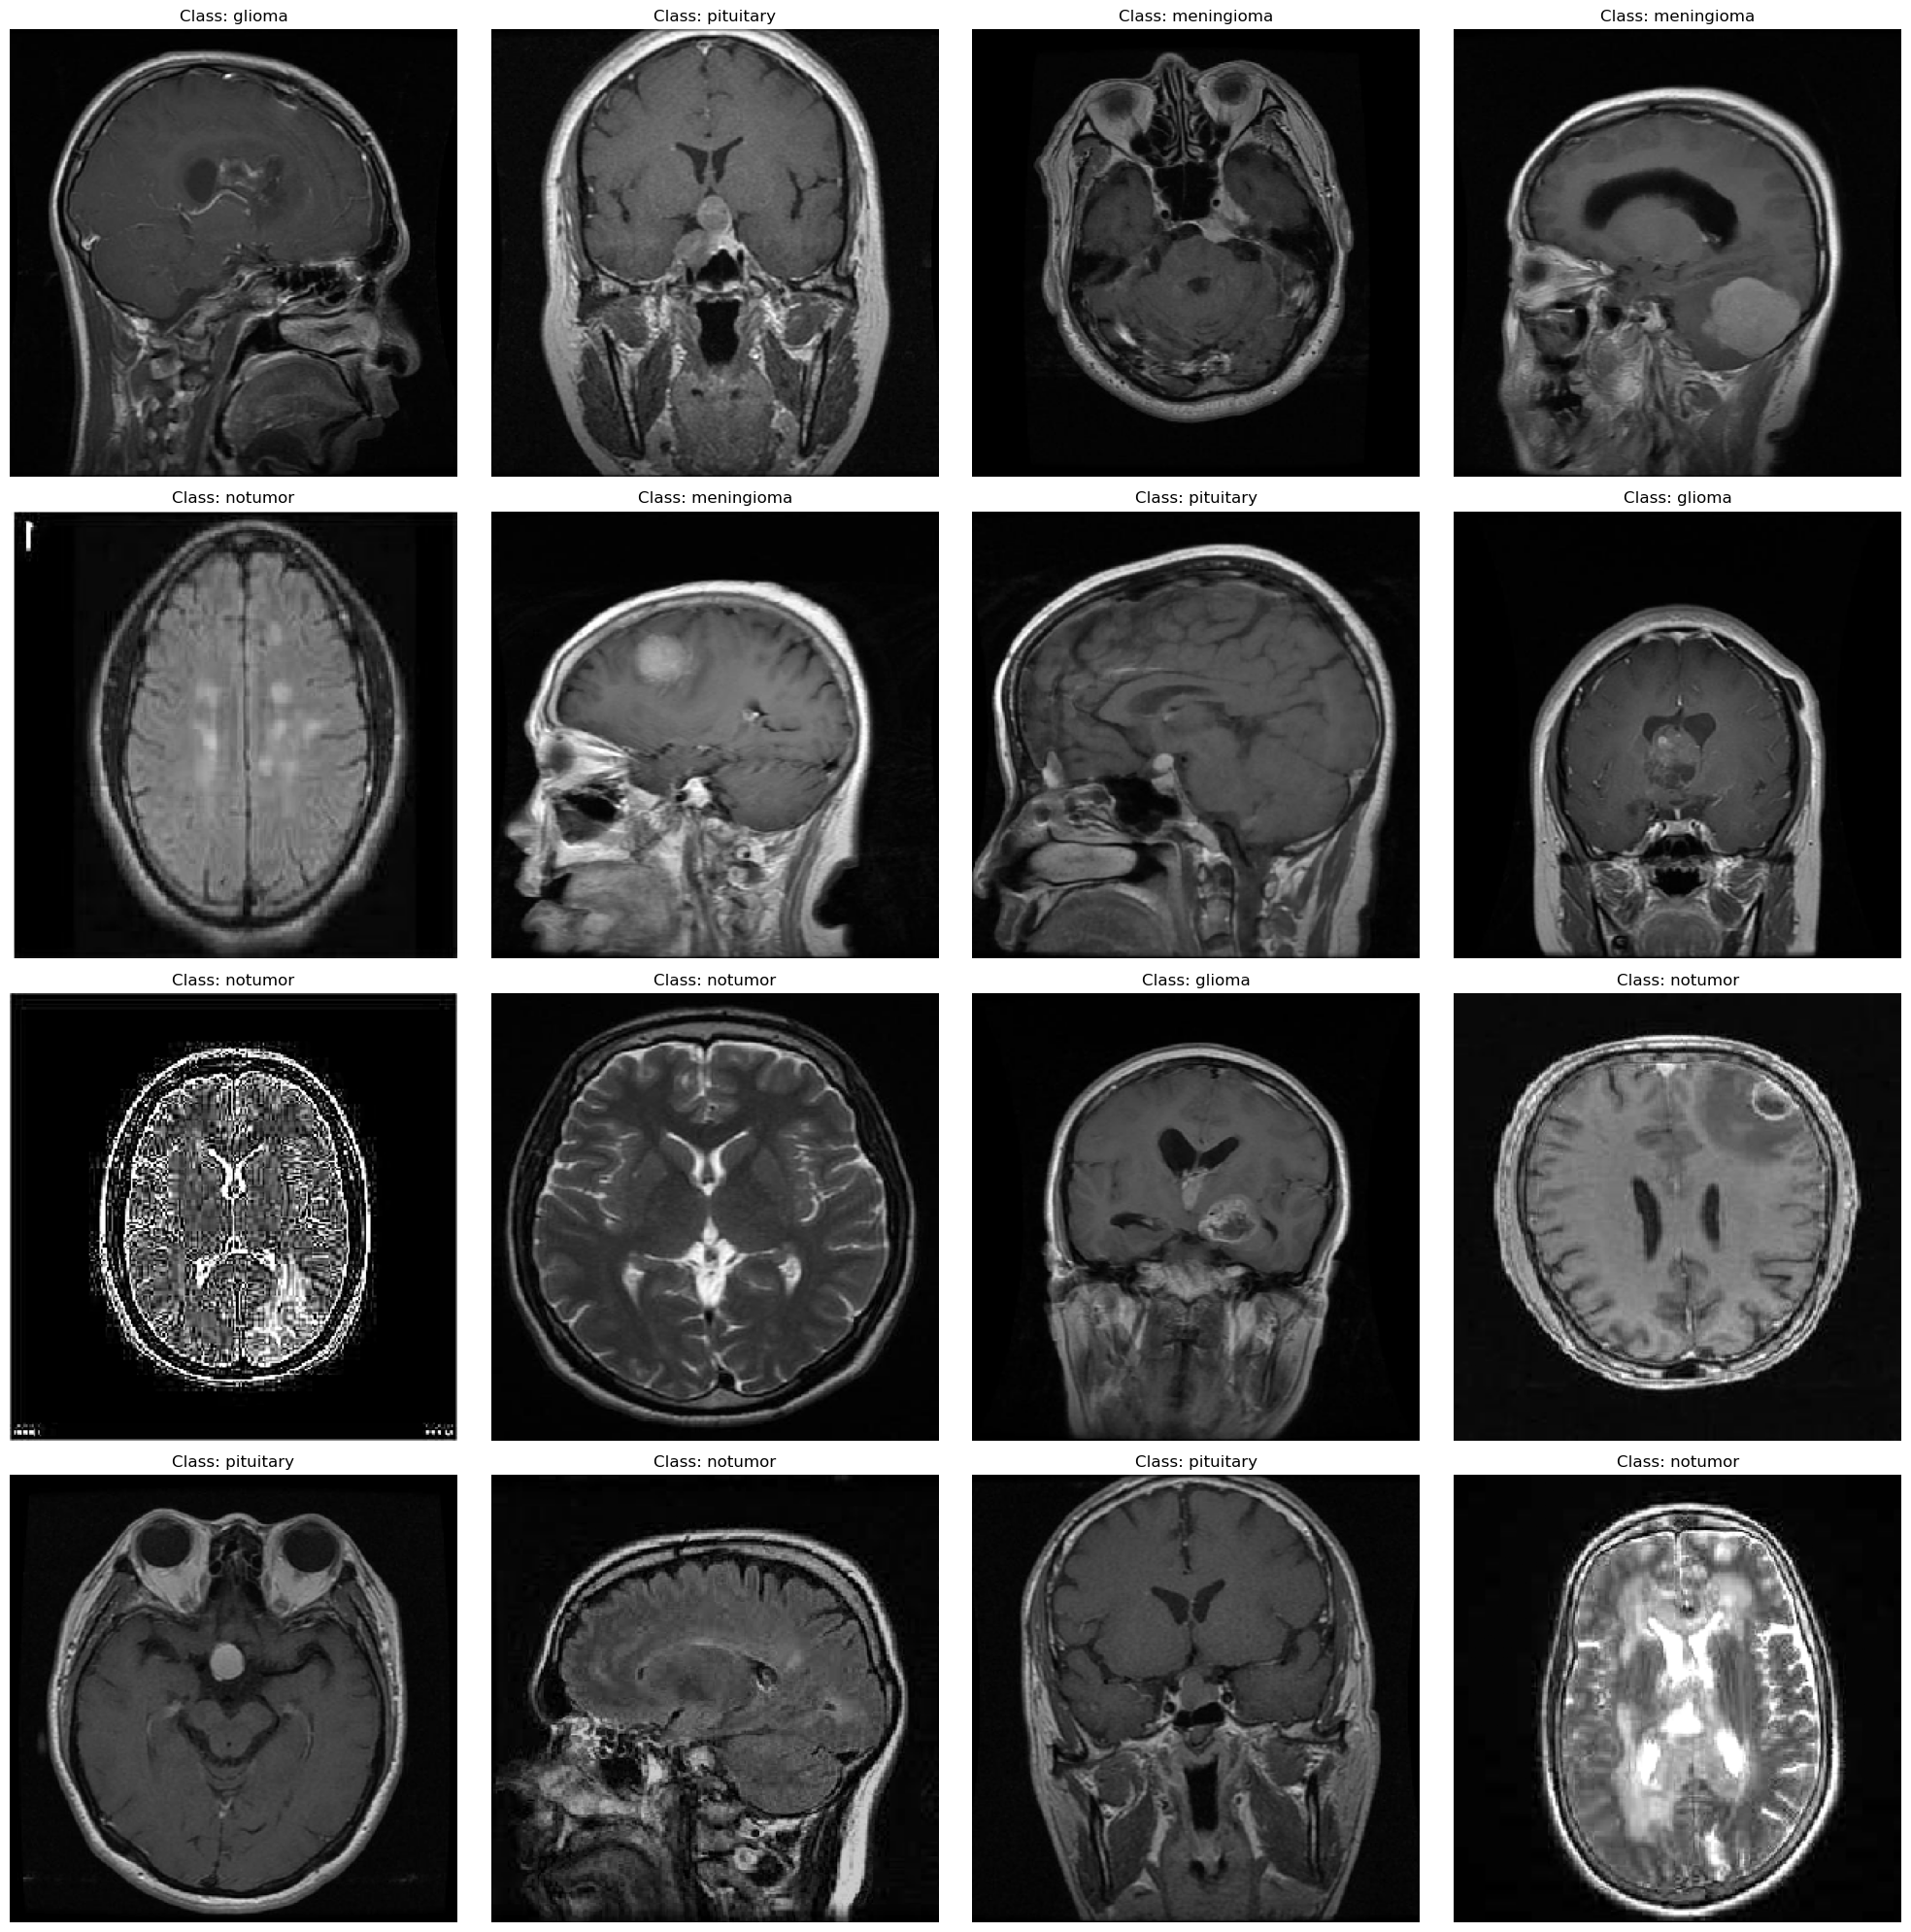

In [15]:
plt.figure(figsize=(20, 20))
for i in range (16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indeies
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape= img_shape, pooling='max')

model = Sequential([base_model, Flatten(), Dropout(rate= 0.3), Dense(128, activation= 'relu'), Dropout(rate= 0.25), Dense(4, activation= 'softmax')])

2024-11-09 13:14:46.947643: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-09 13:14:46.947679: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-09 13:14:46.947688: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-09 13:14:46.947916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-09 13:14:46.947932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

In [ ]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

In [18]:
hist.history.keys()

NameError: name 'hist' is not defined

In [ ]:
  # Get training and validation metrics from history
metrics = ['accuracy', 'precision', 'loss', 'recall']  
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)
    
    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', 
                label=f'Best epoch = {best_epochs[metric]}')
    
    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Training Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Testing Loss: {test_score[0]:.4f}")


/Users/paulc1/miniforge3/envs/tumor-classification/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-09 13:15:28.661820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step


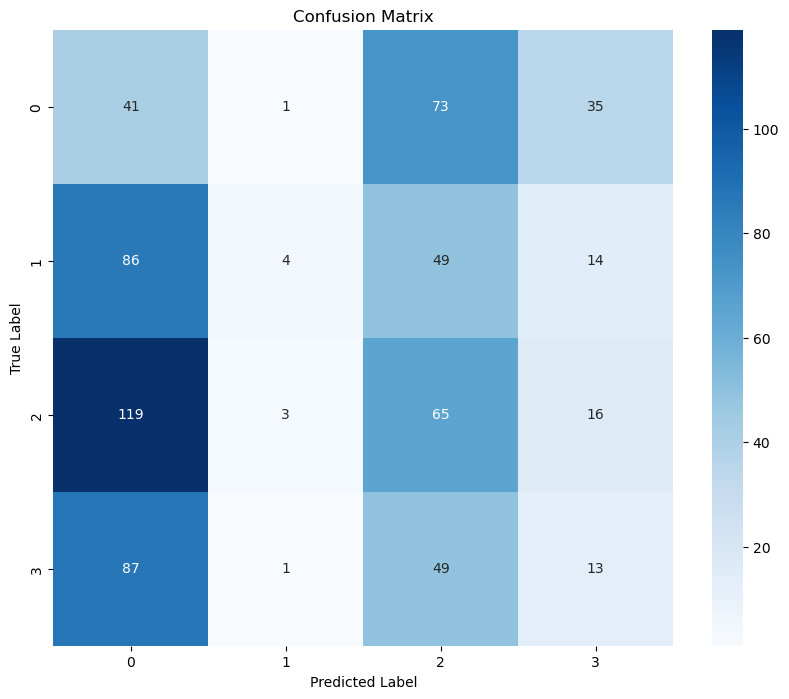

In [19]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
  0: 'glioma',
  1: 'meningioma',
  2: 'no_tumor',
  3: 'pituitary'
}

# Then create a display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from PIL import Image

def predict(img_path: str) -> None:
  # Get class labels
  labels = list(class_dict.keys())

  # Load a process image
  img = Image.open(img_path)
  resized_image = img.resize((299, 299))
  img_array = np.asarray(resized_image)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get Predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_image)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


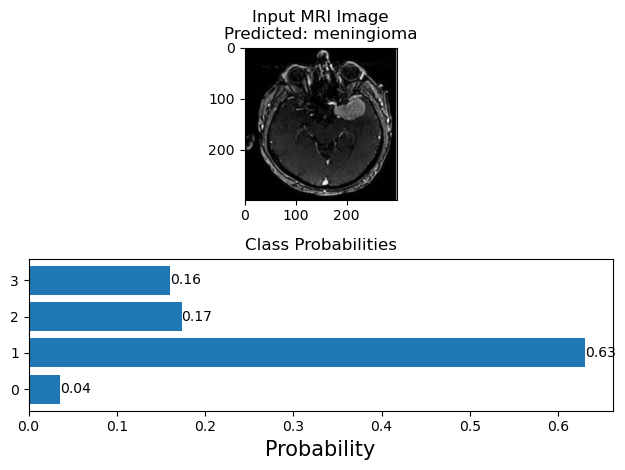


Predicted tumor type: meningioma


In [21]:
predict("Testing/meningioma/Te-me_0011.jpg")

In [ ]:
predict("Testing/meningioma/Te-me_0015.jpg")

In [ ]:
predict("Testing/glioma/Te-gl_0010.jpg")

In [30]:
model.save_weights("xception_model.weights.h5")


In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers


In [23]:
batch_size = 16

img_size = (224, 224)


image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [63]:
# Create a sequential model

cnm_model = Sequential()

# Convolution Layers
cnm_model.add(Conv2D(512, (3, 3), padding= 'same', input_shape=(224, 224, 3), activation= 'relu'))
cnm_model.add(MaxPooling2D(pool_size=(2, 2)))

cnm_model.add(Conv2D(256, (3, 3), padding= 'same', activation= 'relu'))
cnm_model.add(MaxPooling2D(pool_size=(2, 2)))
cnm_model.add(Dropout(0.25))

cnm_model.add(Conv2D(128, (3, 3), padding= 'same', activation= 'relu'))
cnm_model.add(MaxPooling2D(pool_size=(2, 2)))
cnm_model.add(Dropout(0.25))

cnm_model.add(Conv2D(64, (3, 3), padding= 'same', activation= 'relu'))
cnm_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnm_model.add(Flatten())

# Fully connected layers
cnm_model.add(Dense(256, activation= 'relu', kernel_regularizer= regularizers.l2(0.01)))
cnm_model.add(Dropout(0.35))

# Output layer with 4 neurons for the 4 classes
cnm_model.add(Dense(4, activation='softmax'))

# Compile the model
cnm_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

# Display the model summary
cnm_model.summary()

/Users/paulc1/miniforge3/envs/tumor-classification/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = cnm_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 260s 702ms/step - accuracy: 0.5705 - loss: 2.1279 - precision_2: 0.7063 - recall_2: 0.3910 - val_accuracy: 0.6947 - val_loss: 0.9589 - val_precision_2: 0.7219 - val_recall_2: 0.6382
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 250s 699ms/step - accuracy: 0.8079 - loss: 0.7115 - precision_2: 0.8271 - recall_2: 0.7749 - val_accuracy: 0.8183 - val_loss: 0.6224 - val_precision_2: 0.8378 - val_recall_2: 0.7649
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 249s 696ms/step - accuracy: 0.8632 - loss: 0.5134 - precision_2: 0.8740 - recall_2: 0.8498 - val_accuracy: 0.8489 - val_loss: 0.4983 - val_precision_2: 0.8688 - val_recall_2: 0.8290
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 250s 699ms/step - accuracy: 0.8911 - loss: 0.4361 - precision_2: 0.9001 - recall_2: 0.8784 - val_accuracy: 0.8733 - val_loss: 0.4227 - val_precision_2: 0.8823 - val_recall_2: 0.8580
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 251s 701ms/step - accuracy: 0.9093 - loss: 0.3741 - precision_2: 0.9172 - rec

In [65]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])

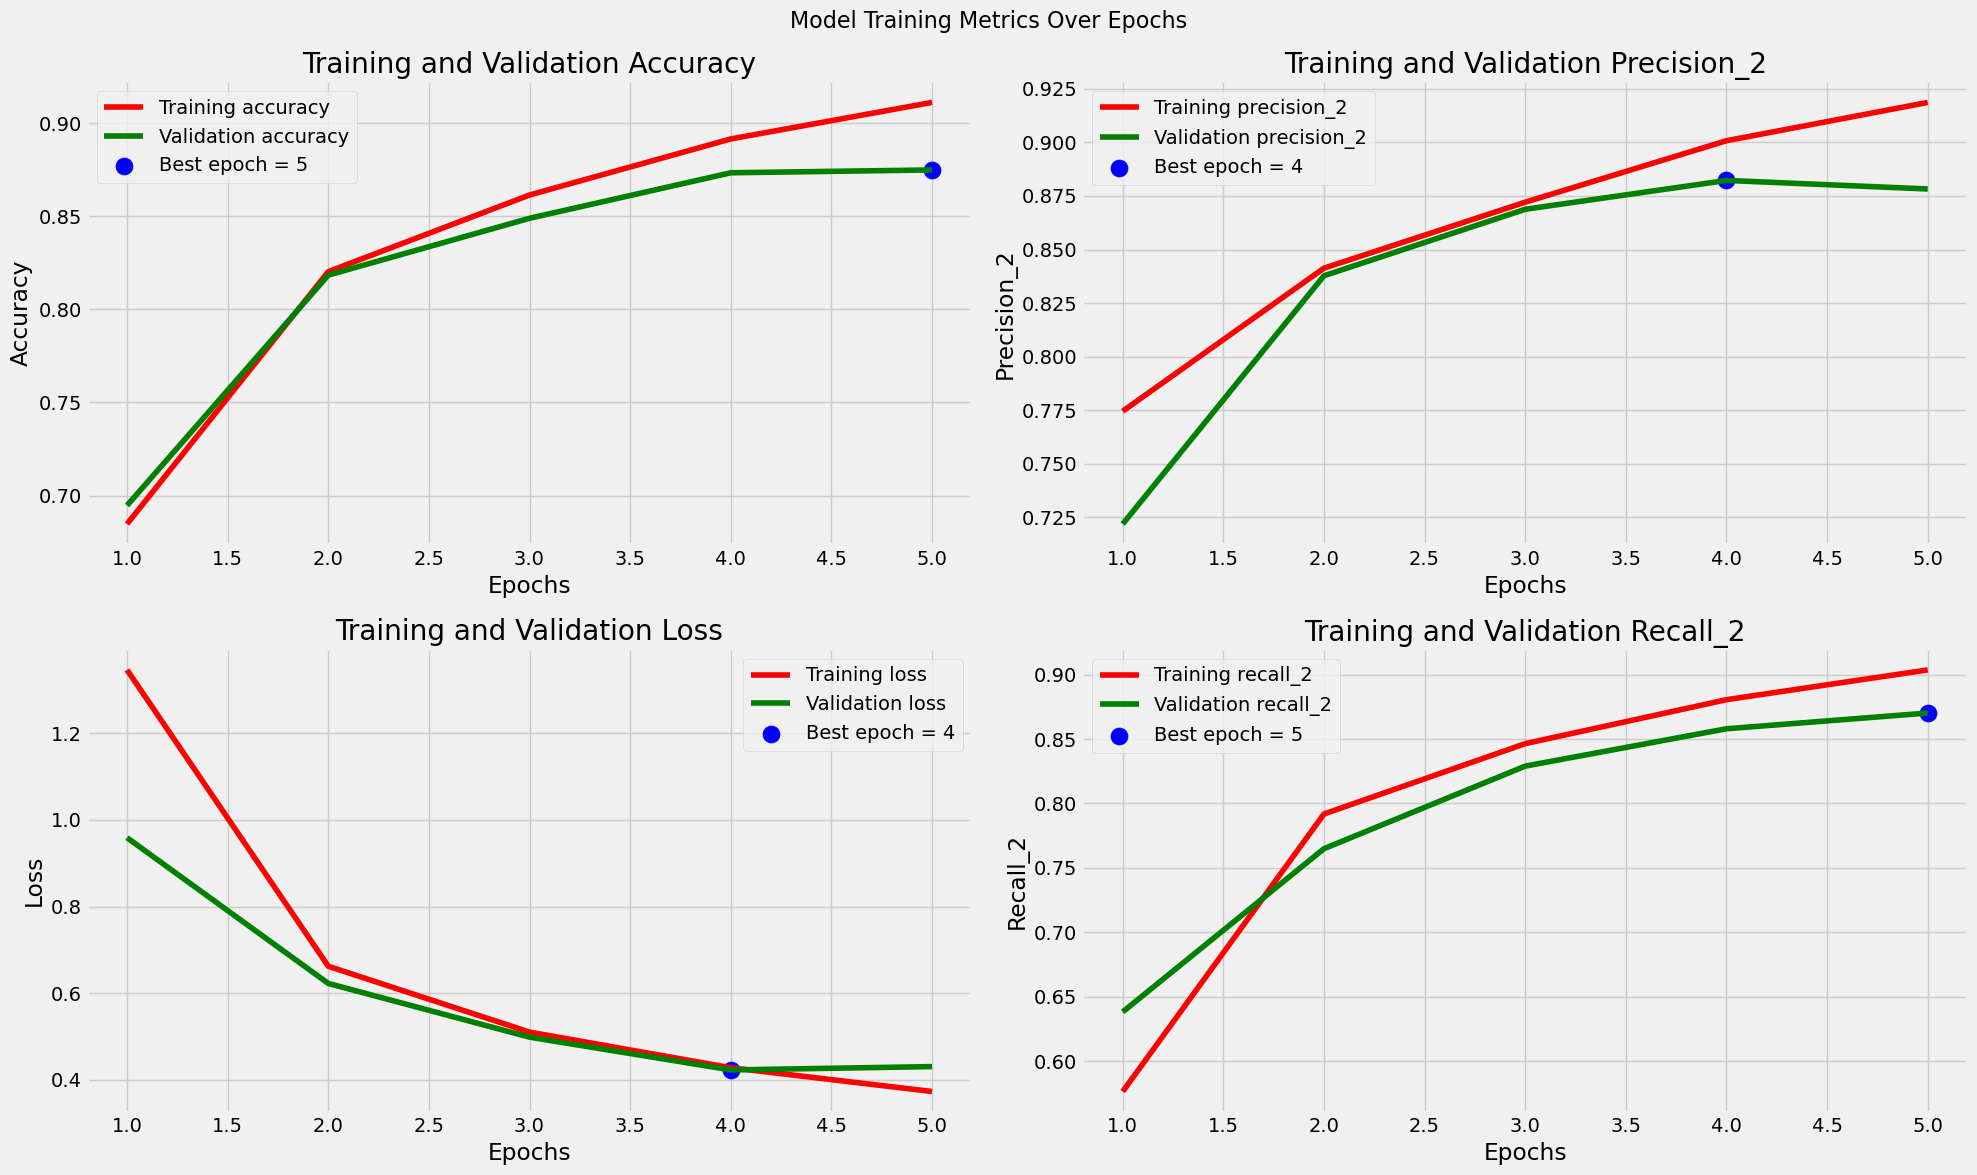

In [67]:
  # Get training and validation metrics from history
metrics = ['accuracy', 'precision_2', 'loss', 'recall_2']  
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)
    
    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', 
                label=f'Best epoch = {best_epochs[metric]}')
    
    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

In [68]:
train_score = cnm_model.evaluate(tr_gen, verbose=1)
valid_score = cnm_model.evaluate(valid_gen, verbose=1)
test_score = cnm_model.evaluate(ts_gen, verbose=1)

print(f"Training Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Testing Loss: {test_score[0]:.4f}")


357/357 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - accuracy: 0.9393 - loss: 0.2950 - precision_2: 0.9450 - recall_2: 0.9348
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8908 - loss: 0.4212 - precision_2: 0.8909 - recall_2: 0.8854
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8862 - loss: 0.4233 - precision_2: 0.8976 - recall_2: 0.8803
Training Accuracy: 93.70%
Validation Loss: 0.4353


Validation Accuracy: 87.33%
Validation Loss: 0.4353


Test Accuracy: 88.26%
Testing Loss: 0.4320


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step


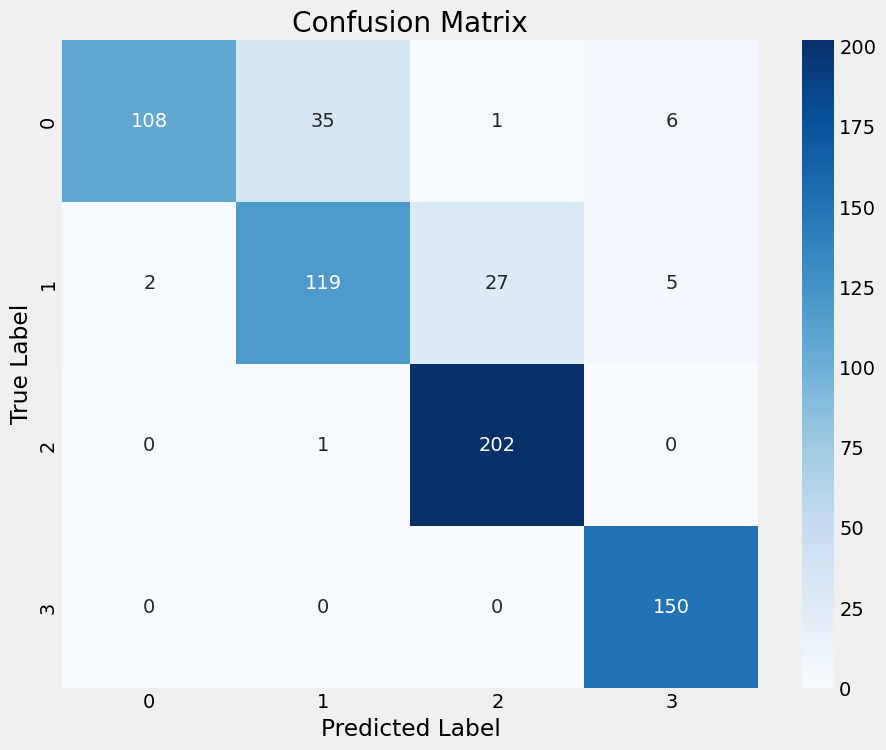

In [69]:
preds = cnm_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
  0: 'glioma',
  1: 'meningioma',
  2: 'no_tumor',
  3: 'pituitary'
}

# Then create a display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [70]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       150
           1       0.77      0.78      0.77       153
           2       0.88      1.00      0.93       203
           3       0.93      1.00      0.96       150

    accuracy                           0.88       656
   macro avg       0.89      0.87      0.88       656
weighted avg       0.89      0.88      0.88       656



In [71]:
cnm_model.save_weights("cnm_model.weights.h5")

# Streamlit app

In [72]:
!pip install streamlit pyngrok python-dotenv



In [73]:
import os
from threading import Thread
from pyngrok import ngrok


In [74]:
from dotenv import load_dotenv
load_dotenv()

ngrok_token = os.getenv('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)


In [75]:
def run_streamlit():
  os.system("streamlit run main.py --server.port 8501")

In [96]:
%%writefile main.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
# import google.generativeai as genai
import PIL.Image
import os
# from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

def load_model(model_path):
    try:
        # Load the entire model
        model = tf.keras.models.load_model(model_path)
        return model
    except:
        # If loading fails, recreate the model architecture and load weights
        model = Sequential([
            Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(256, (3, 3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.35),
            Dense(4, activation='softmax')
        ])
        
        # Compile the model
        model.compile(
            Adamax(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )
        
        # Load weights
        model.load_weights(model_path)
        return model

output_dir = "saliency_maps"
os.makedirs(output_dir, exist_ok=True)

def generate_saliency_map(model, img_array, class_index, img_size):
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match the original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2

    # Apply the mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
      brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_image = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_image * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, 'wb') as f:
      f.write(uploaded_file.getbuffer())

    saliency_map_path = f"saliency_maps/{uploaded_file.name}"

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

def load_xception_model(model_path):
  img_shape = (299, 299, 3)
  base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape= img_shape, pooling='max')

  model = Sequential([base_model, Flatten(), Dropout(rate= 0.3), Dense(128, activation= 'relu'), Dropout(rate= 0.25), Dense(4, activation='softmax')])

  model.build((None,) + img_shape)

  # Compile the model
  model.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

  model.load_weights(model_path)

  return model

st.title("Brain Tumor Classification")

st.write("Upload an image of a brain MRI scan to classify the type of tumor.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:

  selected_model = st.radio(
    "Select Model",
    ("Transfer Learning - Xception", "Custom CNN")  
  )

  if selected_model == "Transfer Learning - Xception":
    model = load_xception_model("xception_model.weights.h5")
    img_size = (299, 299)
  else:
    model = load_model("cnm_model.weights.h5")
    img_size = (224, 224)

  labels = ['Glioma', 'Meningioma', 'No_tumor', 'Pituitary']
  img = image.load_img(uploaded_file, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0

  predictions = model.predict(img_array)

  # Get the class with the highest probability
  class_index = np.argmax(predictions[0])
  result = labels[class_index]

  st.write(f"Predicted Class: {result}")
  st.write("Predictions:")
  for label, prob in zip(labels, predictions[0]):
    st.write(f"{label}: {prob:.4f}")

  saliency_map = generate_saliency_map(model, img_array, class_index, img_size)

  col1, col2 = st.columns(2)
  with col1:
    st.image(uploaded_file, caption="Uploaded Image", use_container_width=True)
  with col2:
    st.image(saliency_map, caption="Saliency Map", use_container_width=True)



Overwriting main.py


In [91]:
thread = Thread(target=run_streamlit)
thread.start()

In [92]:
# from pyngrok import ngrok

# Kill all running tunnels
# ngrok.kill()

public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)

tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)
print("\n")

public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)

print("Public URL:", public_url)

Closing tunnel: https://34b3-199-115-195-99.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://df05-199-115-195-99.ngrok-free.app -> http://localhost:8501


Public URL: NgrokTunnel: "https://846c-199-115-195-99.ngrok-free.app" -> "http://localhost:8501"


5.24.1
